<a href="https://colab.research.google.com/github/guilhermegreis/processamento-de-img/blob/main/C%C3%B3pia_de_Processamento_de_imagens_T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lendo imagem e mostrando

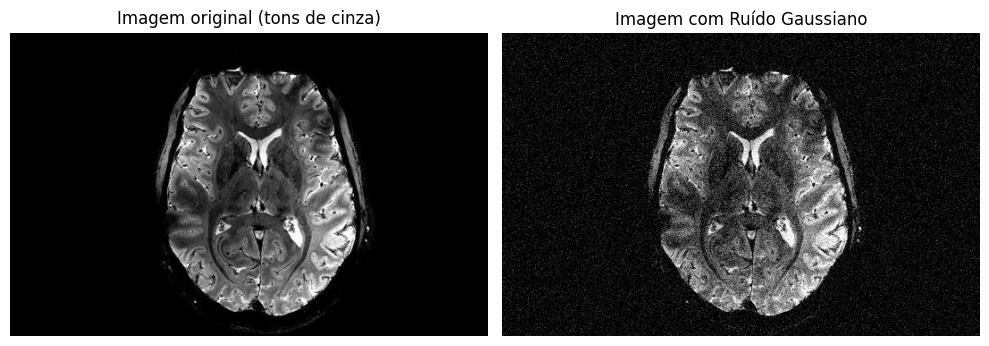

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

def load_img(path):
  try:
    img_rgb = Image.open(path).convert('RGB')
    img_np = np.array(img_rgb)
    height, width, _ = img_np.shape
    gray = np.zeros((height, width), dtype=np.uint8)
    for i in range(height):
      for j in range(width):
        r, g, b = img_np[i, j]
        gray[i, j] = int(0.299 * r + 0.587 * g + 0.114 * b)
    return gray
  except FileNotFoundError:
    print("Imagem não encontrada")
    return None

def add_gaussian_noise(img, mean=0, std_dev=25):
  height, width = img.shape
  noise = np.zeros((height, width), dtype=np.float32)
  for i in range(height):
    for j in range(width):
      #gerar ruído gaussiano com média e desvio padrão
      noise_value = np.random.normal(mean, std_dev)
      noise[i, j] = img[i, j] + noise_value
  #garantir que os valores estejam entre 0 e 255
  noisy_img = np.clip(noise, 0, 255).astype(np.uint8)
  return noisy_img

#caminho e carregamento da imagem
img_path = 'Cerebro-RaioX.png'
img = load_img(img_path)

if img is not None:
  #aplicar ruído
  noisy_img = add_gaussian_noise(img)

  #exibir imagens
  plt.figure(figsize=(10, 4))

  plt.subplot(1, 2, 1)
  plt.imshow(img, cmap='gray')
  plt.title("Imagem original (tons de cinza)")
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(noisy_img, cmap='gray')
  plt.title("Imagem com Ruído Gaussiano")
  plt.axis('off')

  plt.tight_layout()
  plt.show()

iltro da média (suavização)

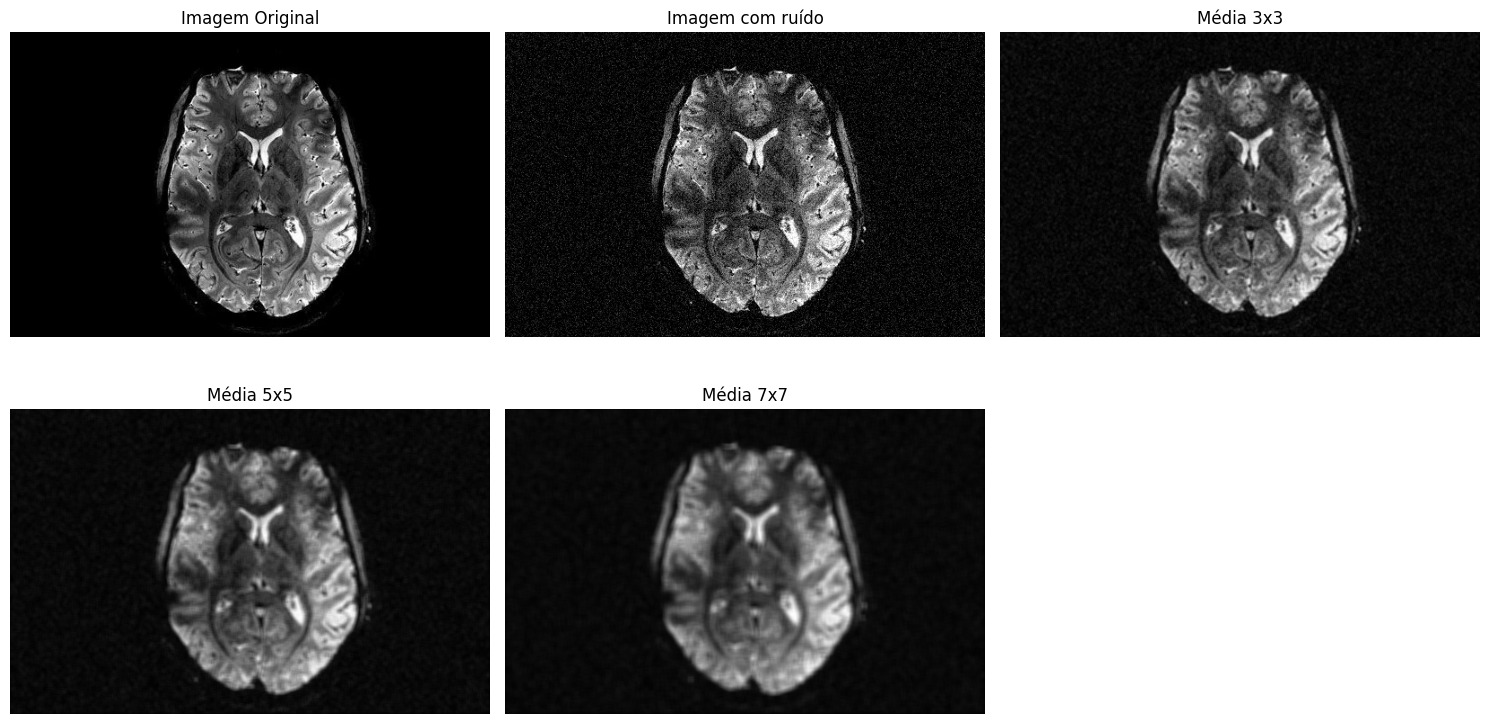

In [ ]:
#criação kernel da média
def create_mean_kernel(size):
  return np.ones((size, size)) / (size * size)

#convulação
def convulation(img, kernel):
  k = kernel.shape[0]
  pad = k//2
  height, width = img.shape
  padded = np.zeros((height + 2 * pad, width + 2 * pad), dtype=np.float32)

  #colocar a imagem para o centro do pad
  for i in range(height):
    for j in range(width):
      padded[i + pad, j + pad] = img[i, j]

  output = np.zeros((height, width), dtype=np.float32)

  for i in range(height):
    for j in range(width):
      acc = 0.0
      for m in range(k):
        for n in range(k):
          acc += padded[i + m, j + n] * kernel[m, n]
      output[i, j] = acc
  return np.clip(output, 0, 255).astype(np.uint8)

#aplicar filtros de média com tamanhos variados
def apply_mean_filters(img, kernel_sizes=[3, 5, 7]):
  results = []
  for size in kernel_sizes:
    kernel = create_mean_kernel(size)
    filtered = convulation(img, kernel)
    results.append({
        'size': size,
        'mean': filtered
    })
  return results

#exibir imagens
def display_mean_filters(original, noisy, filtered_images):
  plt.figure(figsize=(15, 8))

  plt.subplot(2, 3, 1)
  plt.imshow(original, cmap='gray')
  plt.title("Imagem Original")
  plt.axis('off')

  plt.subplot(2, 3, 2)
  plt.imshow(noisy, cmap='gray')
  plt.title("Imagem com ruído")
  plt.axis('off')

  idx = 3
  for res in filtered_images:
    plt.subplot(2, 3, idx)
    plt.imshow(res['mean'], cmap='gray')
    plt.title(f'Média {res["size"]}x{res["size"]}')
    plt.axis('off')
    idx += 1

  plt.tight_layout()
  plt.show()

#execução
img_path = 'Cerebro-RaioX.png'
img = load_img(img_path)

if img is not None:
  noisy_img = add_gaussian_noise(img)
  filtered = apply_mean_filters(noisy_img)
  display_mean_filters(img, noisy_img, filtered)

Filtro da mediana (remoção de ruído)

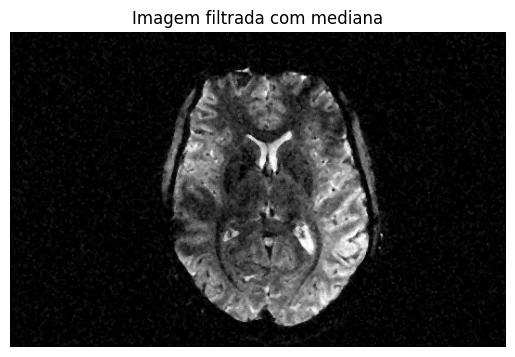

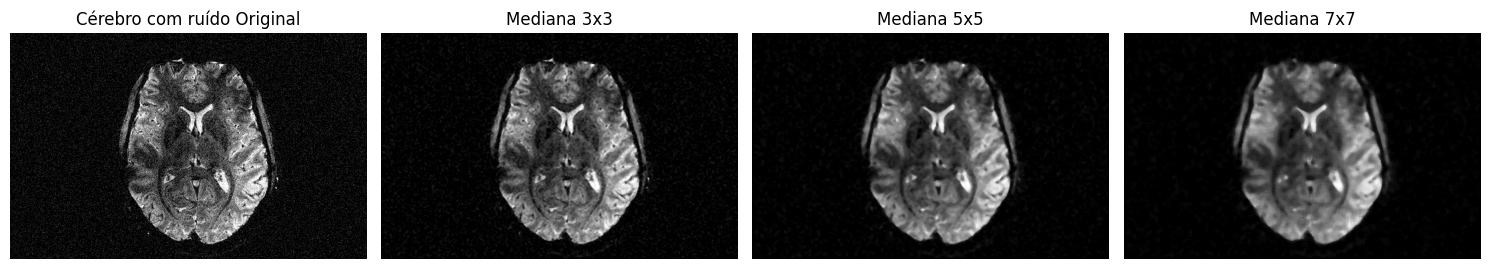

In [ ]:
import matplotlib.pyplot as plt
import cv2

#funcao para aplicar padding
def pad_image(img, pad):
    height = len(img)
    width = len(img[0])
    new_height = height + 2 * pad
    new_width = width + 2 * pad

    padded = [[0 for _ in range(new_width)] for _ in range(new_height)]

    for i in range(height):
        for j in range(width):
            padded[i + pad][j + pad] = img[i][j]
    return padded

#calculo da mediana
def median(values):
    sorted_vals = sorted(values)
    n = len(sorted_vals)
    mid = n // 2
    if n % 2 == 0:
        return (sorted_vals[mid - 1] + sorted_vals[mid]) // 2
    else:
        return sorted_vals[mid]

def median_filter(img, k=3):
    pad = k // 2
    height = len(img)
    width = len(img[0])
    padded = pad_image(img, pad)

    result = [[0 for _ in range(width)] for _ in range(height)]

    for i in range(height):
        for j in range(width):
            window = []
            for ki in range(k):
                for kj in range(k):
                    window.append(padded[i + ki][j + kj])
            result[i][j] = median(window)

    return np.array(result, dtype=np.uint8)

#aplicacao do filtro com varios tamanhos
def apply_filters_medians(img, sizes=[3, 5, 7]):
  results = []
  for k in sizes:
    result = median_filter(img, k)
    results.append((k, result))
  return results

#exibicao
def show_results(original, results, img_name="Imagem"):
  plt.figure(figsize=(15, 5))
  plt.subplot(1, len(results)+1, 1)
  plt.imshow(original, cmap='gray')
  plt.title(f"{img_name} Original")
  plt.axis('off')

  for idx, (k, img_filt) in enumerate(results, start=2):
    plt.subplot(1, len(results)+1, idx)
    plt.imshow(img_filt, cmap='gray')
    plt.title(f"Mediana {k}x{k}")
    plt.axis('off')

  plt.tight_layout()
  plt.show()

#execucao
img = load_img("Cerebro-RaioX.png")
noisy_img = add_gaussian_noise(img)

brain_median = median_filter(noisy_img)
plt.imshow(brain_median, cmap='gray')
plt.title("Imagem filtrada com mediana")
plt.axis('off')
plt.show()

median_results = apply_filters_medians(noisy_img)
show_results(noisy_img, median_results, img_name="Cérebro com ruído")

Filtro Laplaciano (realce de bordas)

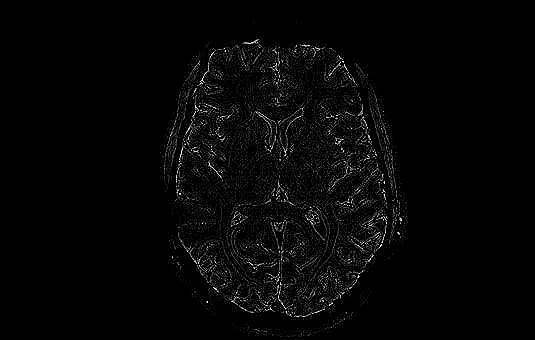

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

#funcao de converter a imagem BGR para listas de listas
def bgr_to_list(img_cv2):
    return [[tuple(pixel) for pixel in row] for row in img_cv2]

#converter imagem BGR para tons de cinza
def rgb_to_gray(img_color):
    height = len(img_color)
    width = len(img_color[0])
    gray = [[0 for _ in range(width)] for _ in range(height)]
    for i in range(height):
        for j in range(width):
            b, g, r = img_color[i][j]
            gray[i][j] = int(0.299 * r + 0.587 * g + 0.114 * b)
    return gray

#padding
def pad_image(img, pad=1):
    height = len(img)
    width = len(img[0])
    padded = [[0 for _ in range(width + 2 * pad)] for _ in range(height + 2 * pad)]
    for i in range(height):
        for j in range(width):
            padded[i + pad][j + pad] = img[i][j]
    return padded

#Laplaciano
def laplacian_filter(img):
    kernel = [[0, -1, 0],
              [-1, 4, -1],
              [0, -1, 0]]
    padded = pad_image(img, 1)
    height = len(img)
    width = len(img[0])
    result = [[0 for _ in range(width)] for _ in range(height)]

    for i in range(height):
        for j in range(width):
            soma = 0
            for ki in range(3):
                for kj in range(3):
                    valor_pixel = padded[i + ki][j + kj]
                    valor_kernel = kernel[ki][kj]
                    soma += valor_pixel * valor_kernel
            #clamping
            result[i][j] = min(255, max(0, soma))

    result_img = np.array(result, dtype=np.uint8)
    return result_img

img_cerebro = cv2.imread("/content/Cerebro-RaioX.png")

img_cerebro_list = bgr_to_list(img_cerebro)

img_cerebro_gray = rgb_to_gray(img_cerebro_list)

laplaciano_cerebro = laplacian_filter(img_cerebro_gray)

cv2_imshow(laplaciano_cerebro)


#Filtro Passa-Baixa com Fourier


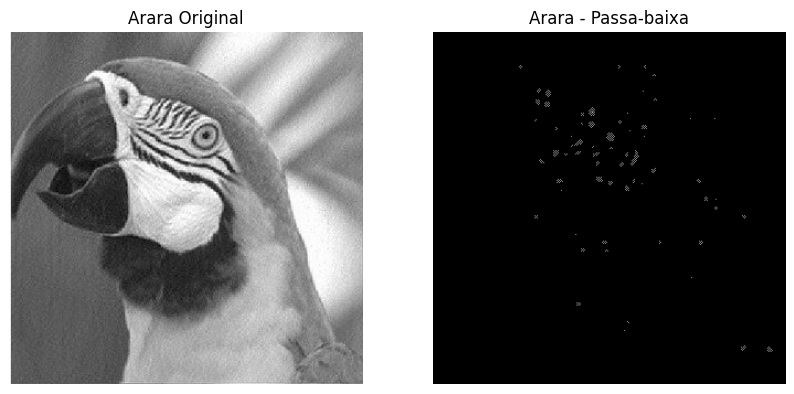

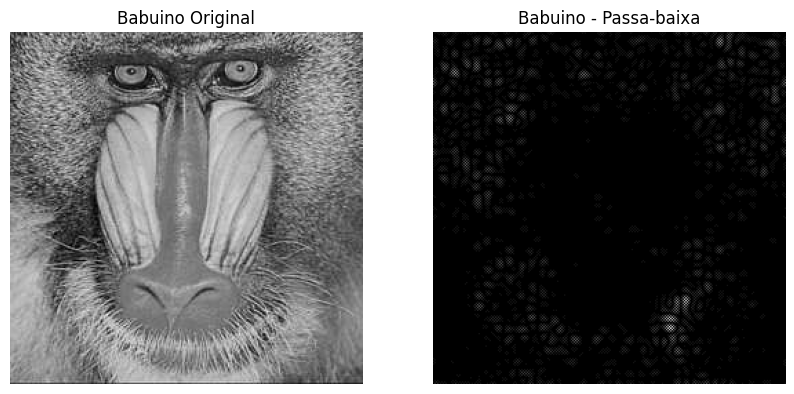

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Função para a Transformada de Fourier 2D usando numpy
def fft2_numpy(img):
    return np.fft.fft2(img)

# Função inversa da Transformada de Fourier 2D usando numpy
def ifft2_numpy(F):
    return np.fft.ifft2(F).real

# Filtro Passa-Baixa usando numpy
def filtro_passa_baixa(img, raio=30):
    F = fft2_numpy(img)  # Transformada de Fourier 2D

    M, N = img.shape
    crow, ccol = M // 2, N // 2  # Centro da imagem

    # Máscara passa-baixa
    for u in range(M):
        for v in range(N):
            distance = np.sqrt((u - crow) ** 2 + (v - ccol) ** 2)
            if distance > raio:
                F[u, v] = 0  # Zera as altas frequências

    # Inversa da Transformada de Fourier
    img_filtro = ifft2_numpy(F)

    # Normaliza os valores para a faixa [0, 255]
    img_filtro = np.clip(img_filtro, 0, 255).astype(np.uint8)

    return img_filtro

# Carregar imagem em tons de cinza
def load_img(path):
    img_rgb = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_rgb is None:
        raise ValueError(f"Imagem não encontrada em {path}")
    return img_rgb

# Exemplo de uso
img_arara = load_img("/content/arara.jpg")
img_babuino = load_img("/content/babuino.jpg")

img_arara_pb = filtro_passa_baixa(img_arara)
img_babuino_pb = filtro_passa_baixa(img_babuino)

# Exibindo as imagens
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Arara Original")
plt.imshow(img_arara, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Arara - Passa-baixa")
plt.imshow(img_arara_pb, cmap='gray')
plt.axis('off')

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Babuino Original")
plt.imshow(img_babuino, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Babuino - Passa-baixa")
plt.imshow(img_babuino_pb, cmap='gray')
plt.axis('off')

plt.show()


#Filtro Passa-Alta com Fourier

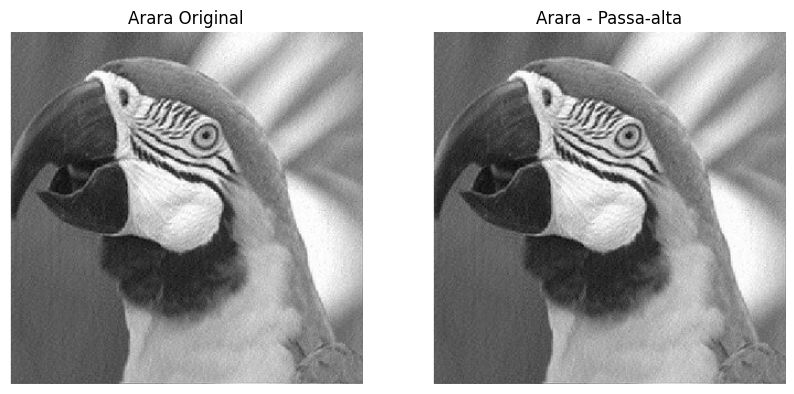

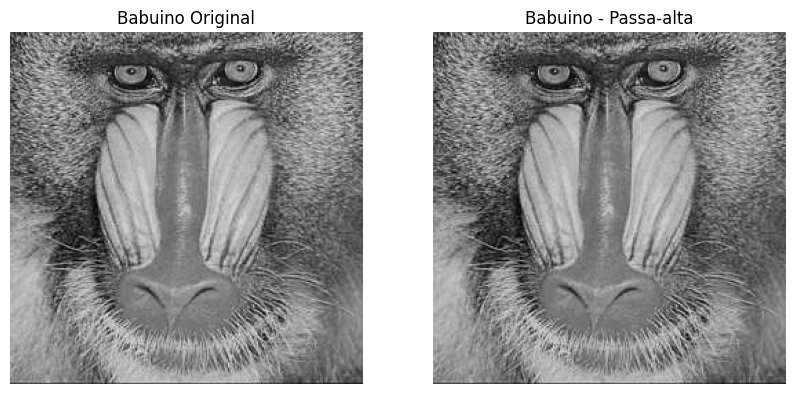

In [ ]:
import math
import cmath
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Função otimizada para a Transformada de Fourier 1D manual com NumPy para vetorização
def fft1d_manual(arr):
    N = len(arr)
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, arr)

# Função otimizada para a Transformada de Fourier 2D manual com NumPy para vetorização
def fft2_manual(img):
    M, N = img.shape
    # FFT nas linhas (direção horizontal)
    F = np.array([fft1d_manual(img[i]) for i in range(M)])

    # FFT nas colunas (direção vertical)
    F_transpose = np.transpose(F)
    F_final = np.array([fft1d_manual(F_transpose[i]) for i in range(N)])

    return np.transpose(F_final)

# Função inversa da Transformada de Fourier 2D manual
def ifft2_manual(F):
    M, N = F.shape

    # Aplicar IFFT 1D nas linhas
    f = np.array([ifft1d_manual(F[i]) for i in range(M)])

    # Aplicar IFFT 1D nas colunas
    f_transpose = np.transpose(f)
    f_final = np.array([ifft1d_manual(f_transpose[i]) for i in range(N)])

    return np.transpose(f_final)

# Função para a IFFT 1D manual com NumPy
def ifft1d_manual(arr):
    N = len(arr)
    f = np.zeros(N, dtype=complex)
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(2j * np.pi * k * n / N) / N
    return np.dot(M, arr)

# Filtro Passa-Alta Manual (inverso do passa-baixa)
def filtro_passa_alta(img, raio=30):
    F = fft2_manual(img)  # Transformada de Fourier 2D

    M, N = img.shape
    crow, ccol = M // 2, N // 2  # Centro da imagem

    # Máscara passa-alta (inverte a lógica do passa-baixa)
    for u in range(M):
        for v in range(N):
            distance = math.sqrt((u - crow) ** 2 + (v - ccol) ** 2)
            if distance < raio:
                F[u, v] = 0  # Zera as baixas frequências

    # Inversa da Transformada de Fourier
    img_filtro = ifft2_manual(F)

    # Normaliza os valores para a faixa [0, 255]
    img_filtro = np.abs(img_filtro)  # A magnitude é o valor que interessa
    img_filtro = np.clip(img_filtro, 0, 255).astype(np.uint8)  # Normaliza para 0-255

    return img_filtro

# Carregar imagem em tons de cinza
def load_img(path):
    img_rgb = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_rgb is None:
        raise ValueError(f"Imagem não encontrada em {path}")
    return img_rgb

# Exemplo de uso
img_arara = load_img("/content/arara.jpg")
img_babuino = load_img("/content/babuino.jpg")

img_pa_ba = filtro_passa_alta(img_babuino)
img_pa_ar = filtro_passa_alta(img_arara)

# Exibindo as imagens
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Arara Original")
plt.imshow(img_arara, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Arara - Passa-alta")
plt.imshow(img_pa_ar, cmap='gray')
plt.axis('off')

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Babuino Original")
plt.imshow(img_babuino, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Babuino - Passa-alta")
plt.imshow(img_pa_ba, cmap='gray')
plt.axis('off')

plt.show()


#Operações Morfológicas

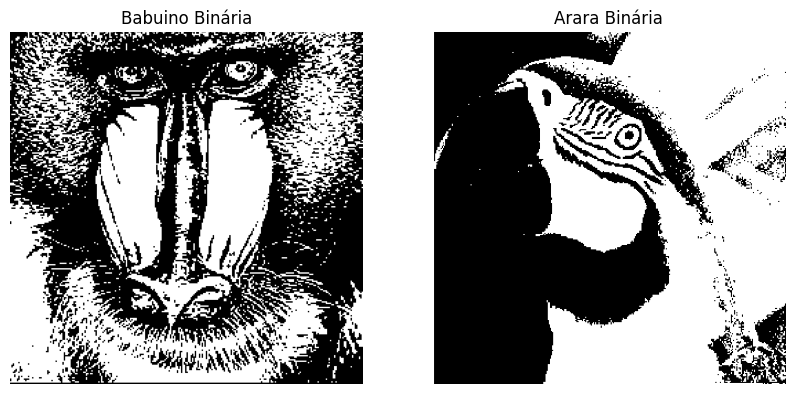

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Função de binarização manual otimizada com NumPy
def binarizar_manual(img, limiar=127):
    # Converter a imagem para um array NumPy
    img = np.array(img)

    # Criar a imagem binária, onde os pixels maiores que o limiar são 255 (branco), e os outros são 0 (preto)
    img_binaria = np.where(img > limiar, 255, 0).astype(np.uint8)

    return img_binaria

# Carregar imagens em tons de cinza
def load_img(path):
    img_rgb = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_rgb is None:
        raise ValueError(f"Imagem não encontrada em {path}")
    return img_rgb

# Carregar as imagens
img_babuino = load_img('/content/babuino.jpg')
img_arara = load_img('/content/arara.jpg')

# Aplicar a binarização nas imagens
img_binaria_babuino = binarizar_manual(img_babuino, 127)
img_binaria_arara = binarizar_manual(img_arara, 127)

# Exibir as imagens binarizadas
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Babuino Binária")
plt.imshow(img_binaria_babuino, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Arara Binária")
plt.imshow(img_binaria_arara, cmap='gray')
plt.axis('off')

plt.show()


2.1 – Dilatação

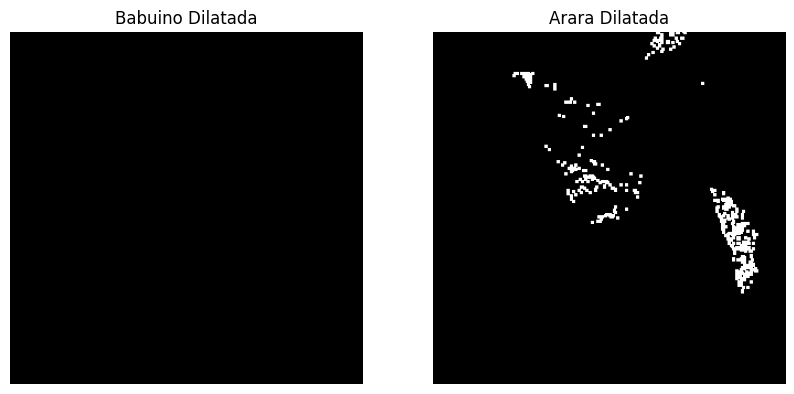

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Função de dilatação manual sem usar funções prontas como np.pad ou np.any
def dilatacao(img, kernel_size=3):
    offset = kernel_size // 2
    # Criar uma imagem preenchida manualmente com zeros
    padded = [[0 for _ in range(len(img[0]) + 2 * offset)] for _ in range(len(img) + 2 * offset)]

    # Copiar a imagem original para a região central da imagem preenchida
    for i in range(len(img)):
        for j in range(len(img[0])):
            padded[i + offset][j + offset] = img[i][j]

    resultado = [[0 for _ in range(len(img[0]))] for _ in range(len(img))]

    # Percorrer a imagem e aplicar a dilatação manualmente
    for i in range(offset, len(padded) - offset):
        for j in range(offset, len(padded[0]) - offset):
            # Extrair a região do kernel (submatriz)
            região = [padded[i - offset + x][j - offset + y] for x in range(kernel_size) for y in range(kernel_size)]
            if 255 in região:  # Verifica se algum valor é 255
                resultado[i - offset][j - offset] = 255

    return resultado

# Carregar as imagens binarizadas
def load_img(path):
    img_rgb = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_rgb is None:
        raise ValueError(f"Imagem não encontrada em {path}")
    return img_rgb

# Carregar as imagens binarizadas (já aplicadas antes)
img_babuino = load_img('/content/babuino.jpg')
img_arara = load_img('/content/arara.jpg')

# Aplicar a dilatação nas imagens binarizadas
img_dilatada_babuino = dilatacao(img_babuino)
img_dilatada_arara = dilatacao(img_arara)

# Exibir as imagens dilatadas
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Babuino Dilatada")
plt.imshow(img_dilatada_babuino, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Arara Dilatada")
plt.imshow(img_dilatada_arara, cmap='gray')
plt.axis('off')

plt.show()


#2.2 – Erosão

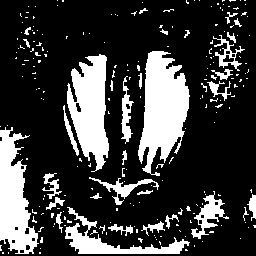

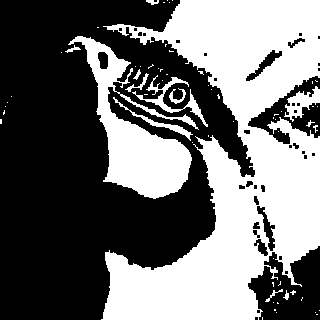

In [ ]:
# Função de erosão manual
def erosao(img, kernel_size=3):
    offset = kernel_size // 2
    # Preencher manualmente a imagem com 255s (borda branca)
    padded = [[255 for _ in range(len(img[0]) + 2*offset)] for _ in range(len(img) + 2*offset)]

    # Copiar a imagem original para a região central da imagem preenchida
    for i in range(len(img)):
        for j in range(len(img[0])):
            padded[i + offset][j + offset] = img[i][j]

    resultado = [[0 for _ in range(len(img[0]))] for _ in range(len(img))]

    # Percorrer a imagem e aplicar a erosão
    for i in range(offset, len(padded) - offset):
        for j in range(offset, len(padded[0]) - offset):
            região = [padded[i - offset + x][j - offset + y] for x in range(kernel_size) for y in range(kernel_size)]
            if all(valor == 255 for valor in região):  # Verifica se todos os valores são 255
                resultado[i - offset][j - offset] = 255

    return resultado

# Carregar as imagens binarizadas
def load_img(path):
    img_rgb = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_rgb is None:
        raise ValueError(f"Imagem não encontrada em {path}")
    return img_rgb

# Carregar as imagens binarizadas (já aplicadas antes)
img_babuino = load_img('/content/babuino.jpg')
img_arara = load_img('/content/arara.jpg')

# Aplicar a erosão nas imagens binarizadas
img_erosao_babuino = erosao(img_babuino)
img_erosao_arara = erosao(img_arara)

# Exibir as imagens de erosão
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Babuino Erosão")
plt.imshow(img_erosao_babuino, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Arara Erosão")
plt.imshow(img_erosao_arara, cmap='gray')
plt.axis('off')

plt.show()

#2.3 – Abertura (erosão seguida de dilatação)

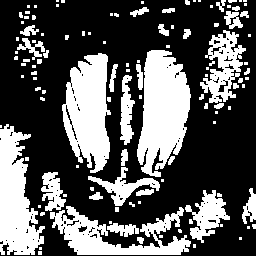

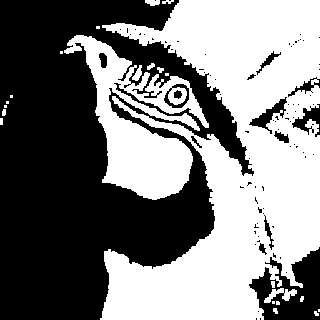

In [ ]:
def abertura(img, kernel_size=3):
    return dilatacao(erosao(img, kernel_size), kernel_size)

img_abertura_babuino = abertura(img_binaria_babuino)
img_abertura_arara = abertura(img_binaria_arara)

cv2_imshow(img_abertura_babuino)
cv2_imshow(img_abertura_arara)


#2.4 – Fechamento (dilatação seguida de erosão)

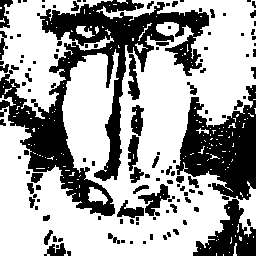

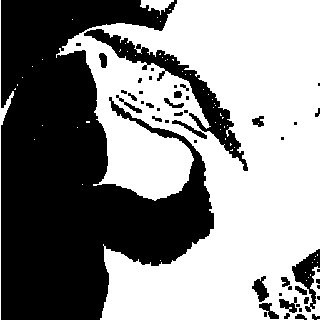

In [ ]:
def fechamento(img, kernel_size=3):
    return erosao(dilatacao(img, kernel_size), kernel_size)

img_fechamento_babuino = fechamento(img_binaria_babuino)
img_fechamento_arara = fechamento(img_binaria_arara)

cv2_imshow(img_fechamento_babuino)
cv2_imshow(img_fechamento_arara)

#Binarização

In [ ]:
def binarizar(img, limiar=127):
    # Criar a imagem binarizada manualmente
    binaria = [[0 for _ in range(len(img[0]))] for _ in range(len(img))]

    for i in range(len(img)):
        for j in range(len(img[0])):
            binaria[i][j] = 255 if img[i][j] > limiar else 0

    return binaria

#Usabilidade


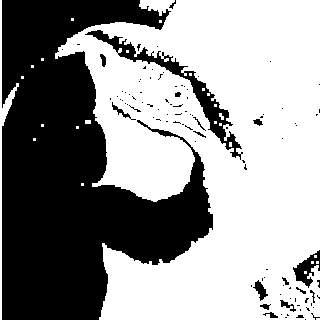

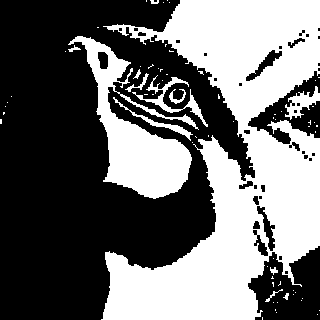

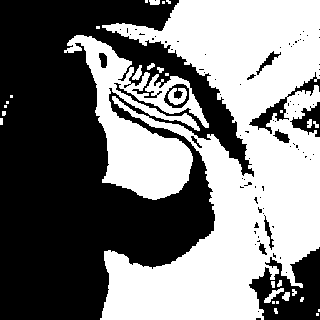

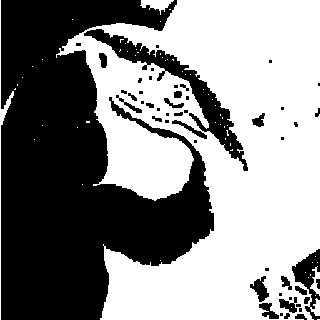

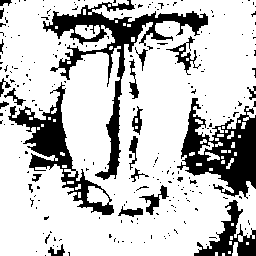

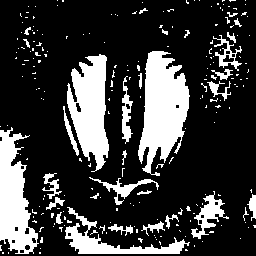

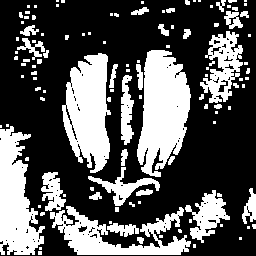

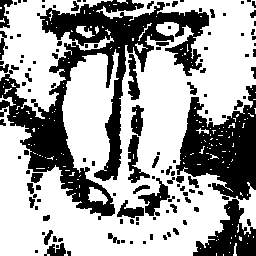

In [ ]:
img_babuino = load_img("/content/babuino.jpg")
img_arara = load_img("/content/arara.jpg")
img_bin_babuino = binarizar(img_babuino, 127)
img_bin_arara = binarizar(img_arara, 127)

img_arara_dilatada = dilatacao(img_bin_arara)
img_arara_erodida = erosao(img_bin_arara)
img_arara_aberta = abertura(img_bin_arara)
img_arara_fechada = fechamento(img_bin_arara)

img_dilatada_babuino = dilatacao(img_bin_babuino)
img_erodida_babuino = erosao(img_bin_babuino)
img_aberta_babuino = abertura(img_bin_babuino)
img_fechada_babuino = fechamento(img_bin_babuino)

cv2_imshow(img_arara_dilatada)
cv2_imshow(img_arara_erodida)
cv2_imshow(img_arara_aberta)
cv2_imshow(img_arara_fechada)

cv2_imshow(img_dilatada_babuino)
cv2_imshow(img_erodida_babuino)
cv2_imshow(img_aberta_babuino)
cv2_imshow(img_fechada_babuino)